# Compisons using Monte Carlo Data

This notebook will take you through the analysis of comparing FlowNet-PET (FNP) to Retrospective Phase Binning (RPB) when binning Monte Carlo PET data based on a clinical breathing trace. Qualitative comparisons are shown.

In [1]:
from flownet import FlowNetPET
from utils import create_normalize, eval_sum, eval_binned
from analysis_mc import (load_phantoms, apply_correction, find_voi, 
                         plot_profile_compare, find_voi2, plot_slices2,
                         find_max_spher)
import configparser
import numpy as np
import torch
import os
import h5py

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

Using Torch version: 1.11.0+cu102
Using a cpu device


Load FlowNet-PET

In [2]:
# Name of saved model
model_name = 'fnp_1'

# Directories
cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')
    
# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)

print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))

# Construct Network
print('\nBuilding networks...')
model = FlowNetPET(architecture_config, device)
model.to(device)

print('\nLoading saved model...')
# Load model info
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['model'])

# Create normalization function for image frames
normalize = create_normalize(checkpoint['x_mean'], checkpoint['x_std'])


Creating model: fnp_1

Configuration:
  DATA
    data_file: xcat_training_set.h5
  TRAINING
    batchsize: 1
    learning_rate: 0.0003
    lr_decay_batch_iters: 8000
    lr_decay: 0.7
    total_batch_iters: 15000
    smooth_weight: 0.0
    res_weights: [1.0, 1.0, 1.0, 1.0]
    l2_weight: 0.0
    inv_weight: 1000.0
  ARCHITECTURE
    input_shape: [108, 152, 152]
    gauss_kernel_len: 15
    gauss_sigma: 0.9
    conv_filts: [16, 32, 64]
    conv_filt_lens: [3, 3, 3]
    conv_strides: [2, 2, 2]
    latent_filters: 256
    interp_mode: bilinear
  Notes
    comment: Original architecture

Building networks...


/arc/home/obriaint/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The flow predictions will have sizes:
108 x 152 x 152
54 x 76 x 76
27 x 38 x 38
14 x 19 x 19

Loading saved model...


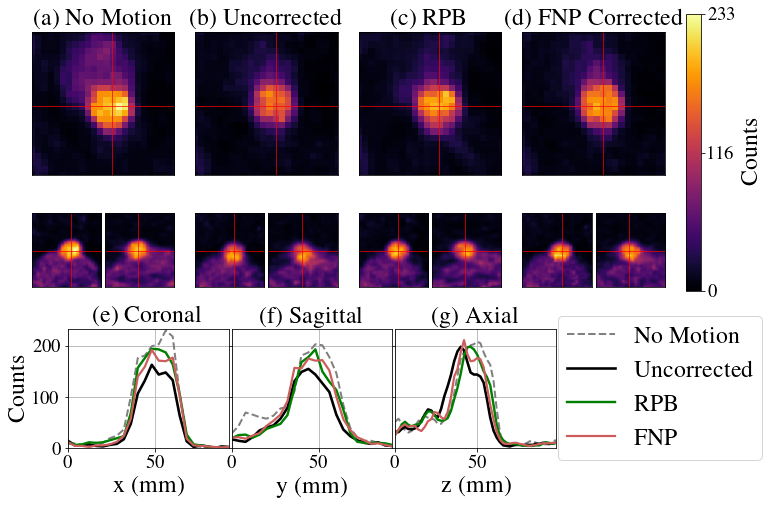

In [3]:
data_file=os.path.join(data_dir, 'mc_rpb_compare_test_set.h5')
avg_counts = 12e6
AP_expansions = [1.2]
pat_num = 5
tgt_bin = 2
n_counts=int(9e6)

for AP_expansion in AP_expansions:

    # Load patient images and info
    (tgt_img, inp_imgs, gt_img, rb_img, rb_phase,
    slice_width, pixel_width, lesn_diameter, tumour_loc) = load_phantoms(data_file, pat_num, AP_expansion, 
                                                                         tgt_bin, tot_counts=n_counts)

    # Apply correction to original frames
    orig_img, corr_img = apply_correction(model, inp_imgs, tgt_img, avg_counts, device, normalize)
    
    # Select VOIs around tumour
    gt_voi = find_voi(gt_img, tumour_loc, lesn_diameter*2, pixel_width, slice_width)
    rb_voi = find_voi(rb_img, tumour_loc, lesn_diameter*2, pixel_width, slice_width)    
    orig_voi = find_voi(orig_img, tumour_loc, lesn_diameter*2, pixel_width, slice_width)
    corr_voi = find_voi(corr_img, tumour_loc, lesn_diameter*2, pixel_width, slice_width)
    
    # Find the spherical VOI with the largest avg
    gt_spher_mask = find_max_spher(gt_voi, lesn_diameter/10, slice_width, pixel_width)
    zyx_centre_gt = np.array([int(np.rint(np.mean(indices))) for indices in np.where(gt_spher_mask)])
    
    plot_profile_compare(orig_voi, gt_voi, corr_voi, rb_voi,
                     rb_phase, vmax_frac=1.,
                     fontsize=24, centre=[zyx_centre_gt, zyx_centre_gt, zyx_centre_gt, zyx_centre_gt],
                     show=True, savename='figures/fig9.pdf')

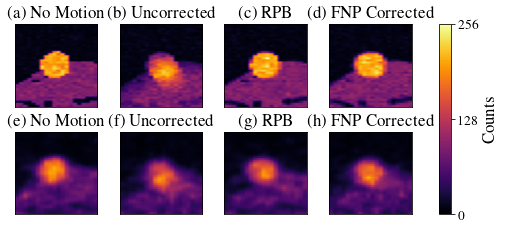

In [4]:
# Load idealized binning VOIs
voi_file = 'data/rpb_compare_VOIs.npz'
voi_data = np.load(voi_file, allow_pickle=True)
zyx_len = voi_data['zyx_len']
gt_voi_id = voi_data['gt_voi']
rb_voi_id = voi_data['rb_voi']
orig_voi_id = voi_data['orig_voi']
corr_voi_id = voi_data['corr_voi']

# Select VOIs for MC data
gt_voi_mc = find_voi2(gt_voi, zyx_centre_gt, zyx_len)
rb_voi_mc = find_voi2(rb_voi, zyx_centre_gt, zyx_len)    
orig_voi_mc = find_voi2(orig_voi, zyx_centre_gt, zyx_len)
corr_voi_mc = find_voi2(corr_voi, zyx_centre_gt, zyx_len)

plot_slices2(gt_voi_id, orig_voi_id, rb_voi_id, corr_voi_id,
             gt_voi_mc, orig_voi_mc, rb_voi_mc, corr_voi_mc,
             vmax_frac=1., fontsize=17,
             show=True, savename='figures/fig7.pdf')